In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


2025-08-27 09:31:07.363868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756287067.533413      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756287067.587124      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("manjilkarki/deepfake-and-real-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/deepfake-and-real-images


In [7]:
# ----------------------------
# 1. Dataset paths
# ----------------------------
dataset_path = "/kaggle/input/deepfake-and-real-images/Dataset"

train_path = os.path.join(dataset_path, "Train")
val_path = os.path.join(dataset_path, "Validation")
test_path = os.path.join(dataset_path, "Test")

In [8]:
# ----------------------------
# Data augmentation pipeline
# ----------------------------
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 128
BATCH_SIZE = 32

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),            # Horizontal flip
    tf.keras.layers.RandomRotation(0.3),                # Rotate ±30%
    tf.keras.layers.RandomZoom(0.2),                    # Zoom ±20%
    tf.keras.layers.RandomContrast(0.2),                # Adjust contrast
    tf.keras.layers.RandomTranslation(0.1, 0.1),        # Translate ±10% in x & y
    tf.keras.layers.RandomBrightness(0.2),              # Adjust brightness
    tf.keras.layers.GaussianNoise(0.05),               # Add Gaussian noise
])

def create_dataset(path, img_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True, augment=False):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        label_mode='int',
        shuffle=shuffle
    )
    
    # Normalize images
    dataset = dataset.map(lambda x, y: (x/255.0, y), num_parallel_calls=AUTOTUNE)
    
    # Apply augmentation if requested
    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                              num_parallel_calls=AUTOTUNE)
    
    return dataset.prefetch(buffer_size=AUTOTUNE)

# ----------------------------
# Create datasets
# ----------------------------
train_dataset = create_dataset(train_path, shuffle=True, augment=True)
val_dataset = create_dataset(val_path, shuffle=False, augment=False)
test_dataset = create_dataset(test_path, shuffle=False, augment=False)


Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.


In [10]:
from tensorflow.keras import layers, models

def build_cnn_deep(input_shape=(128, 128, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),

        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn_deep()
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,306,273 (4.98 MB)

 Trainable params: 1,305,313 (4.98 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ----------------------------
# Callbacks
# ----------------------------
checkpoint = ModelCheckpoint(
    "image_model.h5", 
    save_best_only=True, 
    monitor='val_loss', 
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True, 
    verbose=1
)

# ----------------------------
# Create augmented training dataset
# ----------------------------
train_dataset_aug = create_dataset(train_path, shuffle=True, augment=True)

# ----------------------------
# Train the model
# ----------------------------
history = model.fit(
    train_dataset_aug,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stop],
    verbose=1  # shows progress per batch
)


Found 140002 files belonging to 2 classes.
Epoch 1/20


I0000 00:00:1756287961.410933     105 service.cc:148] XLA service 0x781b9401d100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756287961.411806     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756287961.411884     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756287962.271429     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/4376 ━━━━━━━━━━━━━━━━━━━━ 8:32 117ms/step - accuracy: 0.5156 - loss: 0.8726  

I0000 00:00:1756287970.782694     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5002 - loss: 0.7086
Epoch 1: val_loss improved from inf to 0.69599, saving model to image_model.h5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 551s 122ms/step - accuracy: 0.5002 - loss: 0.7086 - val_accuracy: 0.4981 - val_loss: 0.6960
Epoch 2/20
4375/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5001 - loss: 0.6935
Epoch 2: val_loss improved from 0.69599 to 0.69317, saving model to image_model.h5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 371s 85ms/step - accuracy: 0.5001 - loss: 0.6935 - val_accuracy: 0.4981 - val_loss: 0.6932
Epoch 3/20
1042/4376 ━━━━━━━━━━━━━━━━━━━━ 4:27 80ms/step - accuracy: 0.5081 - loss: 0.6931

341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8981 - loss: 0.2535
Test Loss: 0.2994
Test Accuracy: 0.8854
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━

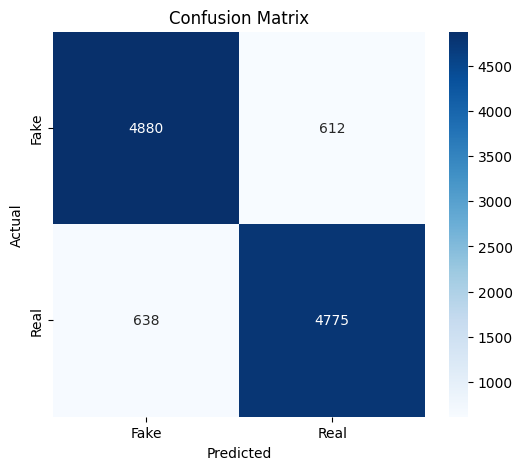

In [32]:
# ----------------------------
# 7. Evaluate on test set
# ----------------------------

# Evaluate using the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# ----------------------------
# 8. Optional: Get detailed predictions
# ----------------------------
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())  # binary threshold

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
print("Classification Report:\n", classification_report(y_true, y_pred))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [33]:
# ----------------------------
# 1. Save the model as .h5
# ----------------------------
model.save("image_model.h5")
print("Model saved as deepfake_model.h5")

# ----------------------------
# 2. Download the model in Kaggle
# ----------------------------
import shutil

# Move file to /kaggle/working/ if not already there
shutil.move("image_model.h5", "/kaggle/working/image_model.h5")
print("Model ready for download from Kaggle output folder.")


Model saved as deepfake_model.h5
Model ready for download from Kaggle output folder.
